# Entry 49 notebook - Decision Trees Analysis and Interpretation

In [334]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
import openml

from sklearn.datasets import load_breast_cancer

from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, fbeta_score

import pydotplus
from sklearn import tree
from IPython.display import Image, display, SVG

import warnings
warnings.simplefilter("once")

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
def score_tree(data, target, tree_clf):
    informedness = make_scorer(balanced_accuracy_score, adjusted=True)
    kappa = make_scorer(cohen_kappa_score)
    mcc = make_scorer(matthews_corrcoef)
    fbet = make_scorer(fbeta_score, beta=0.5)
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target,
                                                        train_size = 0.8, random_state=12)
    scores = cross_validate(tree_clf, X_train, y_train, cv=5, scoring={'Precision':'precision',
                                                                       'Avg_precision':'average_precision',
                                                                       'Recall':'recall','F1':'f1',
                                                                       'Neg_log_loss':'neg_log_loss',
                                                                       'Neg_Brier_score':'neg_brier_score',
                                                                       'informedness':informedness, 'cohen_kappa':kappa,
                                                                       'matthews_corr':mcc, 'f_beta':fbet})
    return pd.DataFrame.from_dict(tree_scores, orient='index')

In [89]:
def tree_importances(data, target, tree_clf):
    X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target,
                                                        train_size = 0.8, random_state=12)
    tree_clf.fit(X_train,y_train)
    table = pd.DataFrame(tree_clf.feature_importances_, index=X_train.columns)
    unimportant = ', '.join(list(table[table[0]==0].index))
    used = table[table[0]!=0]
    used.sort_values(by=0, inplace=True)
    chart = sns.barplot(x=used[0], y=used.index)
    return 'Unused features: ' + unimportant, chart, used

In [409]:
def tree_analysis(data, target, tree_clf, classes):
    X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target,
                                                        train_size = 0.8, random_state=12)
    tree_clf.fit(X_train,y_train)
    train_score = tree_clf.score(X_train,y_train)
    test_score = tree_clf.score(X_test,y_test)
    
    dot_data = tree.export_graphviz(tree_clf, out_file=None,
           feature_names=data.columns,
           class_names = classes,
           rounded=True,
           filled=True)
    graph_image = graphviz.Source(dot_data)
    display(graph_image)
    
    tree_depth = tree_clf.tree_.max_depth
    number_nodes = tree_clf.tree_.node_count
    number_leaves = tree_clf.tree_.n_leaves
    number_features = tree_clf.tree_.n_features
    impurity = tree_clf.tree_.impurity
    number_classes = tree_clf.tree_.max_n_classes
    number_node_samps = tree_clf.tree_.n_node_samples
    tree_node_vals = tree_clf.tree_.value
    node_thresholds = tree_clf.tree_.threshold
    
    node_depth = np.zeros(shape=number_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=number_nodes, dtype=bool)
    stack = [(0, -1)]
    
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
    tree_structure = pd.DataFrame({'gini': impurity,
                                   'nbr_samples': number_node_samps,
                                   'threshold': node_thresholds,
                                   'depth': node_depth, 'leaf': is_leaves})
    
    tree_metrics = pd.DataFrame.from_dict({'Number of features': number_features,
                                           'Number of classes': number_classes,
                                           'Depth of tree': tree_depth,
                                           'Number of nodes': number_nodes,
                                           'Number of leaves': number_leaves,
                                           'Number of non-leaf nodes': number_nodes - number_leaves}, orient='index',
                                          columns=['value'])
    
    col_names = ['min', 'max', 'mean', 'median', 'standard_deviation']
    index_vals = ['leaf_gini', 'leaf_sample', 'split_gini', 'split_sample', 'split_threshold']
    node_vals = [[round(tree_structure.loc[tree_structure['leaf'], 'gini'].min(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'gini'].max(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'gini'].mean(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'gini'].median(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'gini'].std(), 4)],
                 [round(tree_structure.loc[tree_structure['leaf'], 'nbr_samples'].min(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'nbr_samples'].max(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'nbr_samples'].mean(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'nbr_samples'].median(), 4),
                  round(tree_structure.loc[tree_structure['leaf'], 'nbr_samples'].std(), 4)],
                 [round(tree_structure.loc[tree_structure['leaf'] == False, 'gini'].min(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'gini'].max(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'gini'].mean(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'gini'].median(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'gini'].std(), 4)],
                 [round(tree_structure.loc[tree_structure['leaf'] == False, 'nbr_samples'].min(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'nbr_samples'].max(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'nbr_samples'].mean(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'nbr_samples'].median(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'nbr_samples'].std(), 4)],
                 [round(tree_structure.loc[tree_structure['leaf'] == False, 'threshold'].min(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'threshold'].max(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'threshold'].mean(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'threshold'].median(), 4),
                  round(tree_structure.loc[tree_structure['leaf'] == False, 'threshold'].std(), 4)]]
    
    node_metrics = pd.DataFrame(node_vals, columns = col_names, index=index_vals)
    
    gini_distro = sns.displot(data=tree_structure, x='gini', kde=True, hue='leaf', multiple='stack').set(title='Gini Distribution')
    sample_distro = sns.displot(data=tree_structure, x='nbr_samples', kde=True, hue='leaf', multiple='stack').set(title='Sample Distribution')
    threshold_distro = sns.displot(data=tree_structure[tree_structure['leaf'] == False], x='threshold', kde=True).set(title='Threshold Distribution')
    
    return 'Accuracy on train set: ' + str(train_score), 'Accuracy on test set: ' + str(test_score), 'Tree metrics', tree_metrics, 'Node metrics', node_metrics, gini_distro, sample_distro, threshold_distro

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Iris Dataset

In [403]:
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
target = cancer.target

In [404]:
score_tree(data, target, DecisionTreeClassifier())

,0,1,2,3,4
fit_time,0.004374,0.003441,0.003195,0.003475,0.003932
score_time,0.005072,0.004394,0.004431,0.004539,0.006517
test_Precision,0.980769,0.932203,0.948276,0.949153,0.981818
test_Avg_precision,0.943464,0.921473,0.936981,0.943490,0.963111
test_Recall,0.894737,0.964912,0.964912,0.982456,0.947368
test_F1,0.935780,0.948276,0.956522,0.965517,0.964286
test_Neg_log_loss,-2.656838,-2.277317,-1.897761,-1.518214,-1.518197
test_Neg_Brier_score,-0.076923,-0.065934,-0.054945,-0.043956,-0.043956
test_informedness,0.865325,0.847265,0.876677,0.894221,0.917957
test_cohen_kappa,0.840391,0.857441,0.881910,0.904961,0.907190


//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


('Unused features: mean radius, mean perimeter, mean area, mean smoothness, mean concave points, mean symmetry, mean fractal dimension, texture error, perimeter error, smoothness error, symmetry error, worst radius, worst texture, worst perimeter, worst smoothness, worst compactness, worst fractal dimension',
                                 0
 radius error             0.001814
 compactness error        0.006261
 mean compactness         0.007513
 concave points error     0.008050
 mean concavity           0.012022
 worst symmetry           0.013416
 worst concavity          0.016434
 concavity error          0.017801
 fractal dimension error  0.018076
 mean texture             0.020459
 area error               0.044767
 worst area               0.104614
 worst concave points     0.728773)

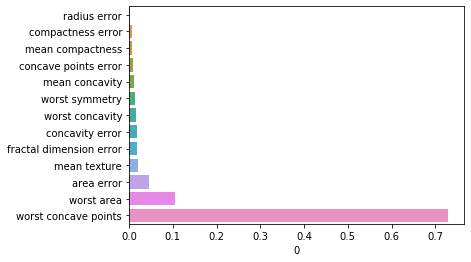

In [405]:
tree_importances(data, target, DecisionTreeClassifier())

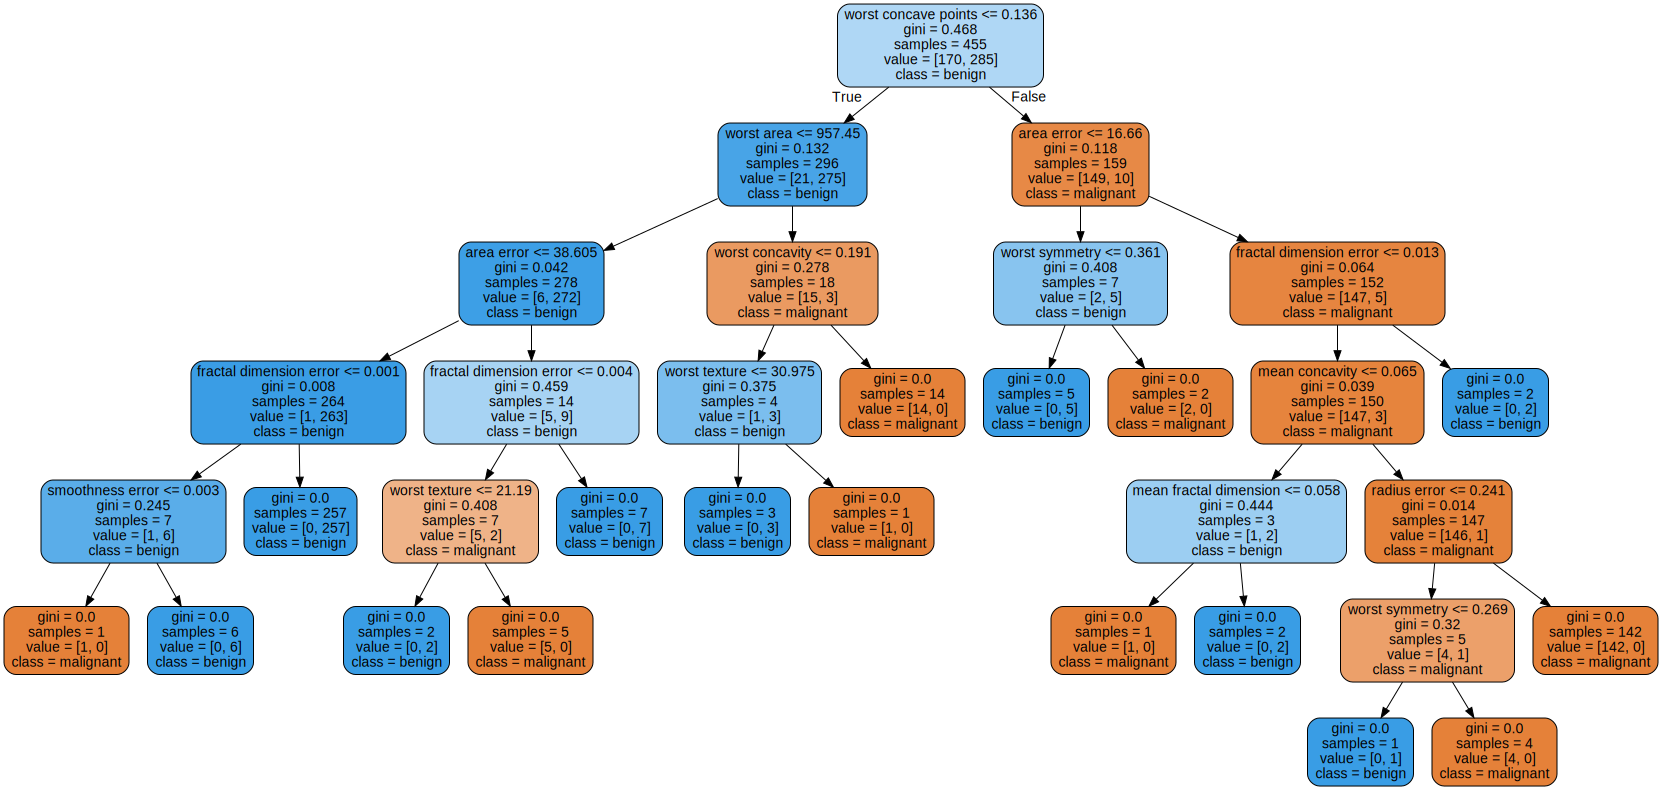

//anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
//anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
//anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None

('Accuracy on train set: 1.0',
 'Accuracy on test set: 0.8859649122807017',
 'Tree metrics',
                           value
 Number of features           30
 Number of classes             2
 Depth of tree                 6
 Number of nodes              33
 Number of leaves             17
 Number of non-leaf nodes     16,
 'Node metrics',
                     min       max      mean   median  standard_deviation
 leaf_gini        0.0000    0.0000    0.0000   0.0000              0.0000
 leaf_sample      1.0000  257.0000   26.7647   3.0000             68.1960
 split_gini       0.0075    0.4681    0.2388   0.2613              0.1764
 split_sample     3.0000  455.0000  122.8750  82.5000            139.8236
 split_threshold  0.0013  957.4500   66.6389   0.2160            237.8845,
 <seaborn.axisgrid.FacetGrid at 0x1a328d5290>)

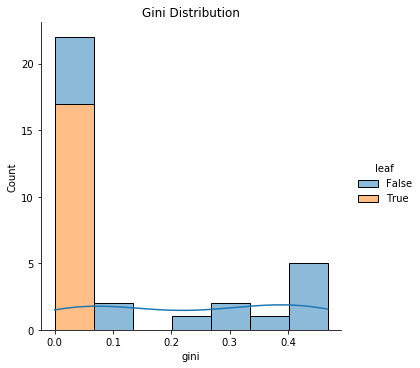

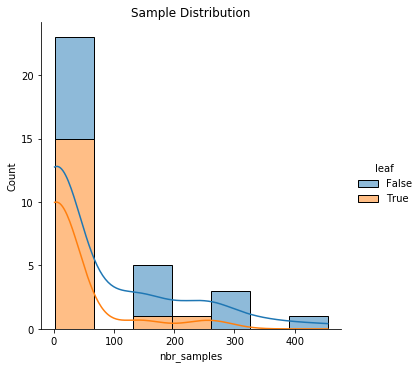

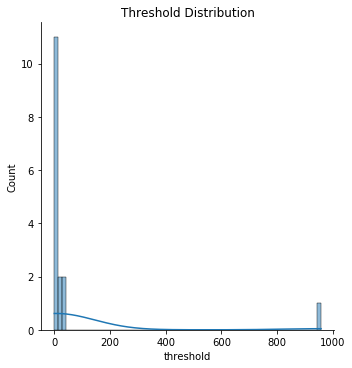

In [411]:
tree_analysis(data, target, DecisionTreeClassifier(), cancer.target_names)

## Titanic Dataset

In [392]:
import category_encoders as ce

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [412]:
titanic = sns.load_dataset('titanic')
drop_cols = ['age', 'who', 'deck', 'embark_town', 'alive', 'class', 'embarked', 'deck']
titanic.drop(drop_cols, axis=1, inplace=True)

binary_cols = ['sex', 'adult_male', 'alone']
index=titanic.index.tolist()
encoder = ce.OrdinalEncoder(cols=binary_cols)
oe_binary = pd.DataFrame(encoder.fit_transform(titanic[binary_cols]), index=index)

titanic_prep = pd.concat([titanic.drop(binary_cols, axis=1), oe_binary], axis=1)

data = titanic_prep.drop('survived', axis=1)
target = titanic_prep['survived']

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
//anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [413]:
score_tree(data, target, DecisionTreeClassifier())

,0,1,2,3,4
fit_time,0.004374,0.003441,0.003195,0.003475,0.003932
score_time,0.005072,0.004394,0.004431,0.004539,0.006517
test_Precision,0.980769,0.932203,0.948276,0.949153,0.981818
test_Avg_precision,0.943464,0.921473,0.936981,0.943490,0.963111
test_Recall,0.894737,0.964912,0.964912,0.982456,0.947368
test_F1,0.935780,0.948276,0.956522,0.965517,0.964286
test_Neg_log_loss,-2.656838,-2.277317,-1.897761,-1.518214,-1.518197
test_Neg_Brier_score,-0.076923,-0.065934,-0.054945,-0.043956,-0.043956
test_informedness,0.865325,0.847265,0.876677,0.894221,0.917957
test_cohen_kappa,0.840391,0.857441,0.881910,0.904961,0.907190


//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('Unused features: ',
                    0
 sex         0.000964
 alone       0.013823
 parch       0.033982
 sibsp       0.039617
 pclass      0.141562
 fare        0.376248
 adult_male  0.393803)

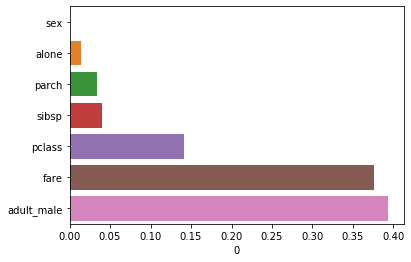

In [414]:
tree_importances(data, target, DecisionTreeClassifier())

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


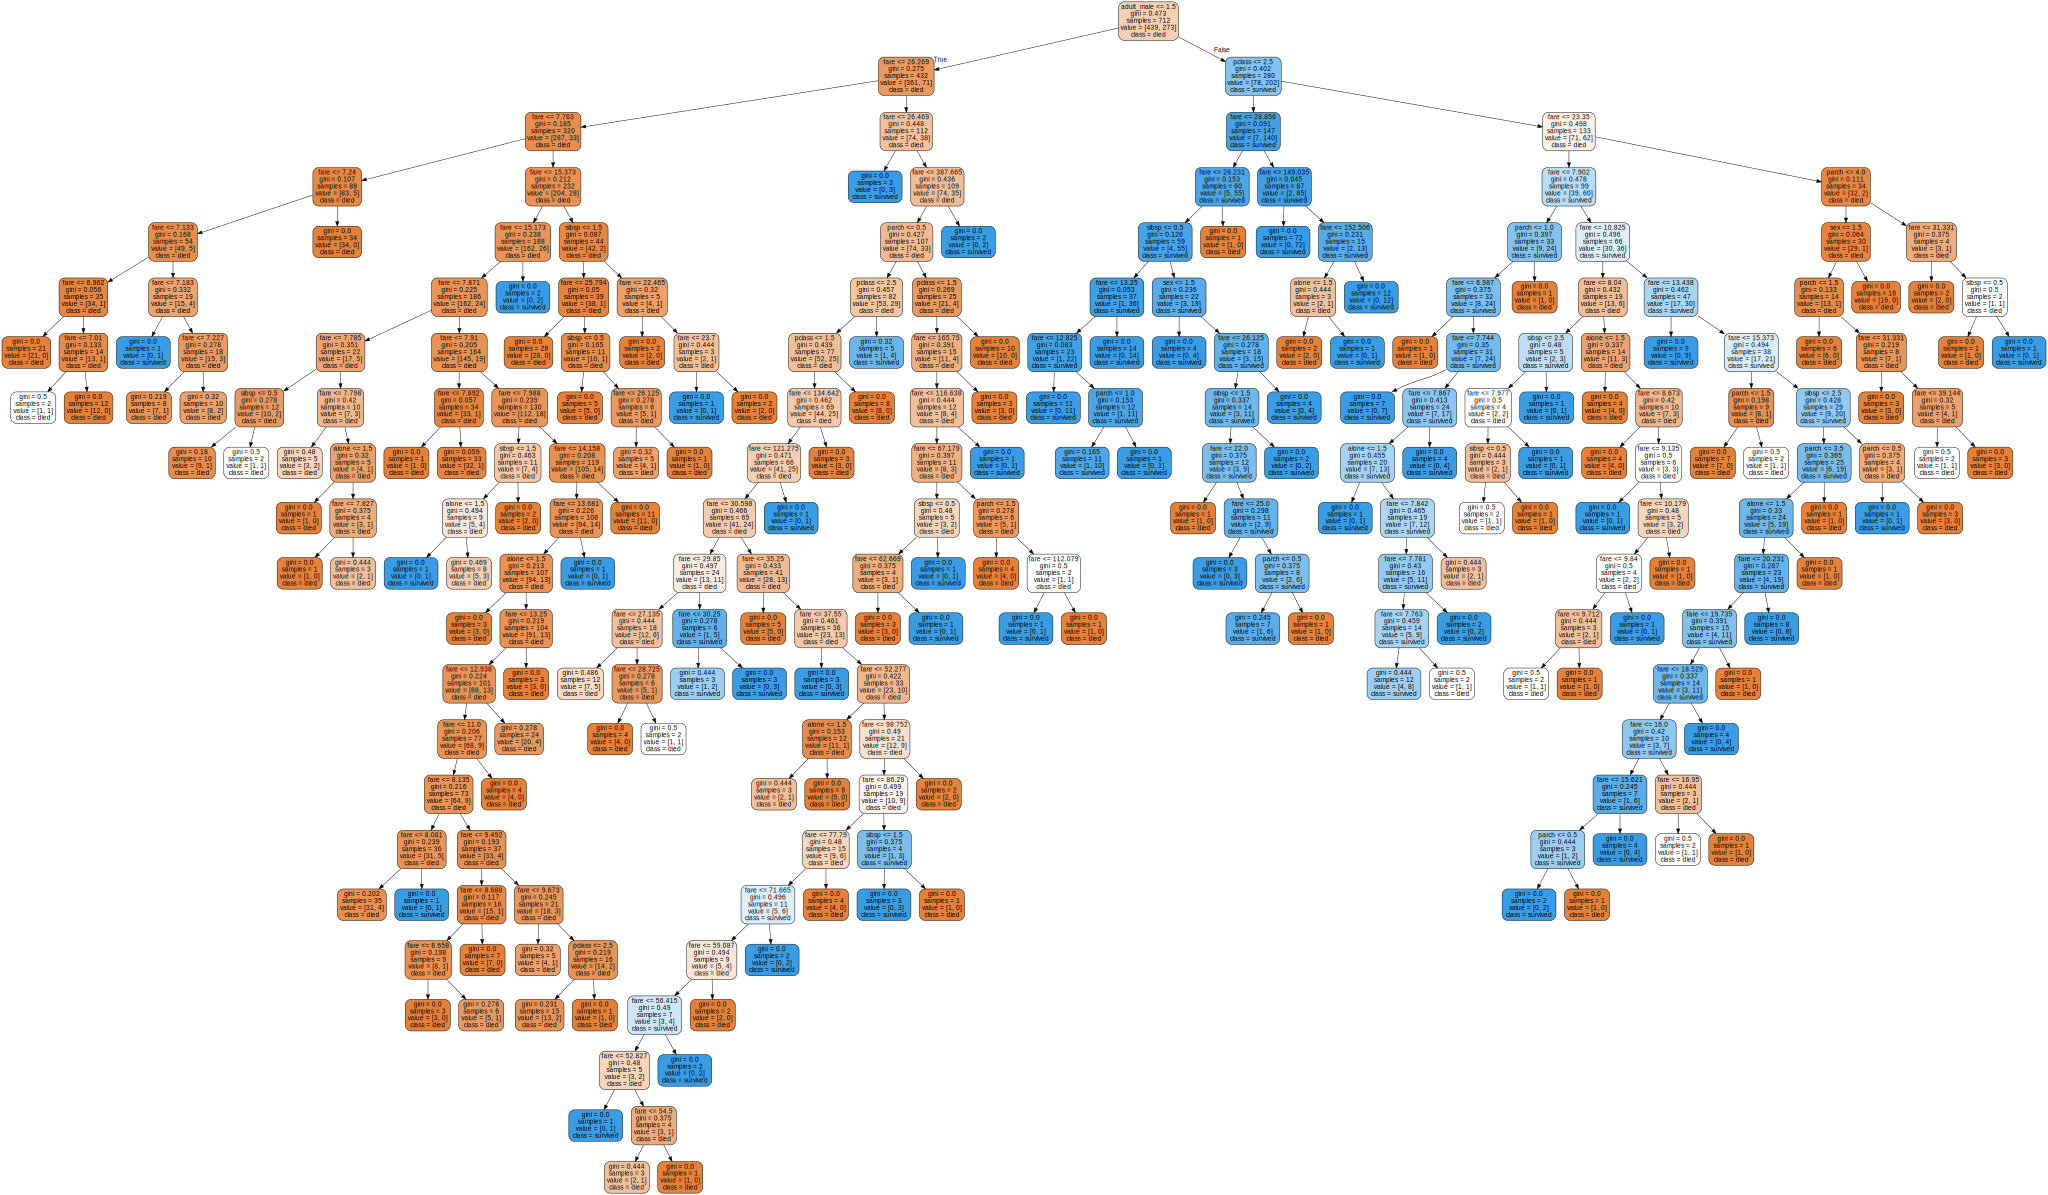

//anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
//anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated a

('Accuracy on train set: 0.9311797752808989',
 'Accuracy on test set: 0.776536312849162',
 'Tree metrics',
                           value
 Number of features            7
 Number of classes             2
 Depth of tree                21
 Number of nodes             265
 Number of leaves            133
 Number of non-leaf nodes    132,
 'Node metrics',
                  min       max     mean   median  standard_deviation
 leaf_gini        0.0    0.4444   0.1608   0.1800              0.1426
 leaf_sample      1.0  232.0000  46.5882  18.0000             72.5888
 split_gini       0.0    0.5000   0.2129   0.2148              0.1998
 split_sample     1.0  712.0000  25.4234   6.0000             64.3286
 split_threshold -2.0  387.6646  12.0039  -2.0000             36.1570,
 <seaborn.axisgrid.FacetGrid at 0x1a328df550>)

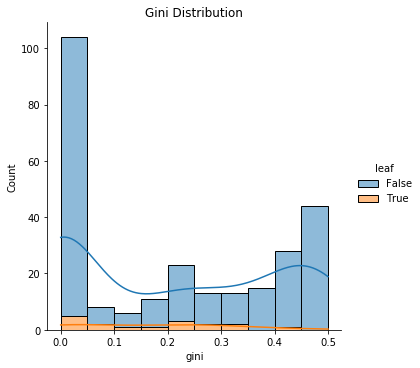

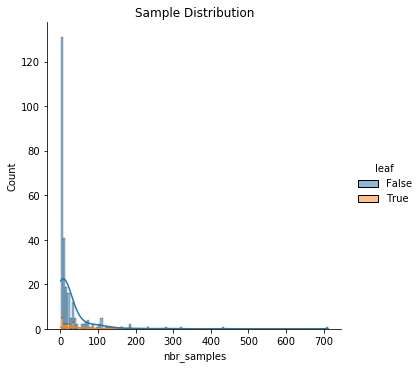

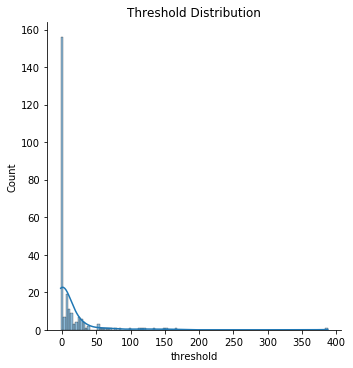

In [415]:
tree_analysis(data, target, DecisionTreeClassifier(), ['died', 'survived'])

# Other

In [152]:
tree_depth = tree_clf.tree_.max_depth
# tree_clf.get_depth()
number_nodes = tree_clf.tree_.node_count
number_leaves = tree_clf.tree_.n_leaves
# tree_clf.get_n_leaves()
number_features = tree_clf.tree_.n_features
# tree_clf.n_features_
impurity = tree_clf.tree_.impurity
number_classes = tree_clf.tree_.max_n_classes
# tree_clf.tree_.n_classes
number_node_samps = tree_clf.tree_.n_node_samples
tree_node_vals = tree_clf.tree_.value

In [115]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [209]:
text = export_text(tree_clf, feature_names=X_train.columns.tolist())
print(text)

|--- worst concave points <= 0.14
|   |--- worst area <= 957.45
|   |   |--- area error <= 38.60
|   |   |   |--- fractal dimension error <= 0.00
|   |   |   |   |--- smoothness error <= 0.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- smoothness error >  0.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- fractal dimension error >  0.00
|   |   |   |   |--- class: 1
|   |   |--- area error >  38.60
|   |   |   |--- fractal dimension error <= 0.00
|   |   |   |   |--- worst texture <= 21.19
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- worst texture >  21.19
|   |   |   |   |   |--- class: 0
|   |   |   |--- fractal dimension error >  0.00
|   |   |   |   |--- class: 1
|   |--- worst area >  957.45
|   |   |--- worst concavity <= 0.19
|   |   |   |--- mean area <= 817.95
|   |   |   |   |--- class: 0
|   |   |   |--- mean area >  817.95
|   |   |   |   |--- class: 1
|   |   |--- worst concavity >  0.19
|   |   |   |--- class: 0
|--- worst concave points >  0.14


In [30]:
tree_clf.predict_proba(X_test)

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])